In [ ]:
#Installing required libraries
!pip install geopandas matplotlib folium ipywidgets
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from ipywidgets import interact

#Loading GeoJson Files
wards = gpd.read_file('Wards_from_2022.geojson')
storm_surge = gpd.read_file('Storm_Surge_Risk_Areas.geojson')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.8 MB/s eta 0:00:00


In [ ]:
#Checking coordinate systems (and reprojecting if needed)
print(f"Wards CRS: {wards.crs}")
print(f"Storm Surge CRS: {storm_surge.crs}")

#Reprojecting to a local CRS (e.g., espg = 26918 for D.C. Wards)
wards = wards.to_crs(epsg=26918)
storm_surge = storm_surge.to_crs(epsg=26918)

#Calculate intersection to find flooded areas within wards
flooded_wards = gpd.overlay(wards, storm_surge, how='intersection')

#Calculate flooded area per ward
flooded_wards['flooded_area'] = flooded_wards.geometry.area
wards['total_area'] = wards.geometry.area

#Merge results
result = wards.merge(
    flooded_wards.groupby('WARD')['flooded_area'].sum().reset_index(),
    on = 'WARD',
    how = 'left'
).fillna(0) #Fills wards with no flood risk as 0

result['flood_pct'] = (result['flooded_area'] / result['total_area']) * 100

#Sorting by most flood-prone wards
result.sort_values('flood_pct', ascending = False, inplace = True)
print(result[['WARD', 'flood_pct']].head(8)) #Shows all 8 wards

Wards CRS: EPSG:4326
Storm Surge CRS: EPSG:4326
   WARD  flood_pct
1     6  28.140591
3     2  18.444991
0     8  13.486583
2     7   9.172365
5     5   2.990070
6     3   1.744317
4     1   0.000000
7     4   0.000000


/tmp/ipython-input-9-1193264551.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0) #Fills wards with no flood risk as 0


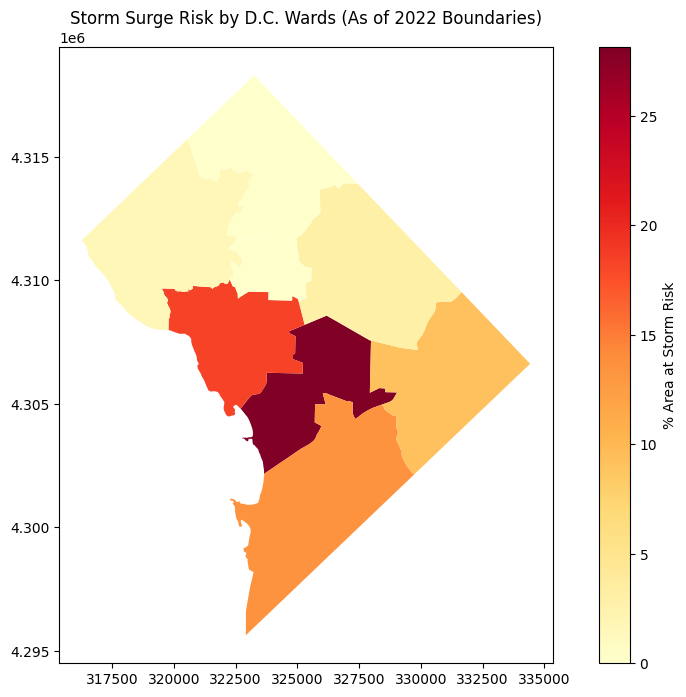

interactive(children=(Dropdown(description='ward', options=(np.int32(6), np.int32(2), np.int32(8), np.int32(7)…

<function __main__.plot_ward(ward)>

In [ ]:
#Visualization with Matplotlib
fig, ax = plt.subplots(figsize = (12, 8))
result.plot(column = 'flood_pct', cmap = 'YlOrRd', legend = True, ax = ax, legend_kwds = {'label': '% Area at Storm Risk'})
plt.title('Storm Surge Risk by D.C. Wards (As of 2022 Boundaries)')
plt.show()

#Interactive folium map with a focus on Wards 7 & 8
def plot_ward(ward):
  ward_data = result[result['WARD'] == ward]
  m = folium.Map(location = [38.895, -77.0369], zoom_start = 12)
  folium.GeoJson(
      ward_data,
      style_function = lambda x: {
          'fillColor': '#ff0000' if x['properties']['flood_pct'] > 15 else '#ff9999', 'color': 'black', 'weight': 1
      },
      tooltip = f"Ward {ward}: {ward_data['flood_pct'].values[0]:.1f} % at risk"
  ).add_to(m)
  display(m)

#Drop down to explore any ward
interact(plot_ward, ward = result['WARD'].unique())